# Optical Flow

Optical flow tracks objects by looking at where the *same* points have moved from one image frame to the next. Let's load in a few example frames of a pacman-like face moving to the right and down and see how optical flow finds **motion vectors** that describe the motion of the face!

As usual, let's first import our resources and read in the images.

# 광학 흐름

광학 흐름은 *동일한* 지점이 한 이미지 프레임에서 다음 이미지 프레임으로 이동한 위치를 보고 객체를 추적합니다. 팩맨과 같은 얼굴이 오른쪽과 아래로 움직이는 몇 가지 예시 프레임을 로드하고 광학 흐름이 얼굴의 움직임을 설명하는 **모션 벡터**를 어떻게 찾는지 살펴보겠습니다!

평소처럼 먼저 리소스를 가져와서 이미지를 읽어들입니다.

In [3]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import matplotlib.image as mpimg  # for reading in images
import matplotlib.pyplot as plt
import cv2  # computer vision library
%matplotlib inline

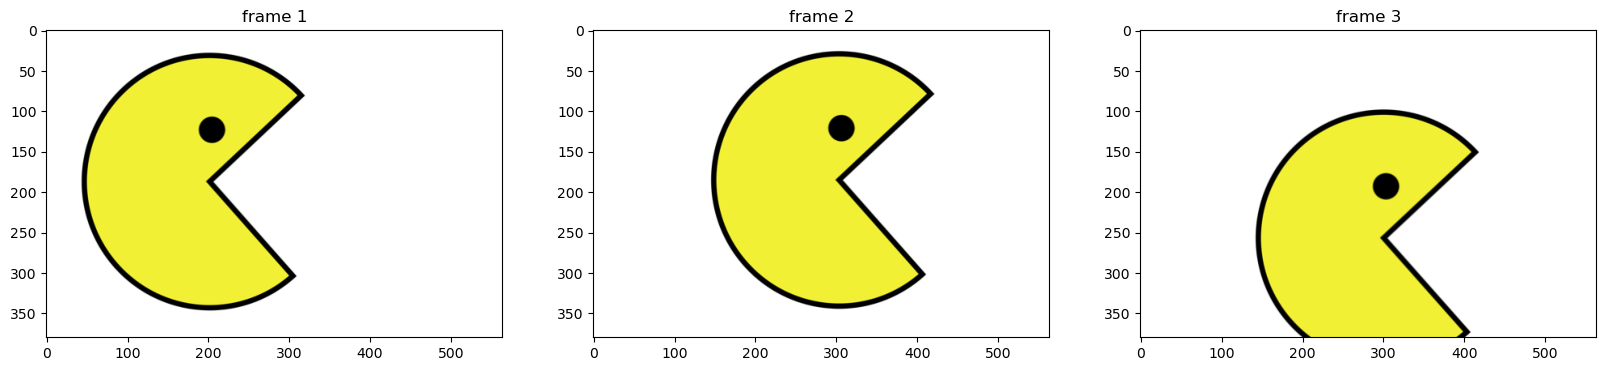

In [12]:
# Read in the image frames
frame_1 = cv2.imread('images/pacman_1.png')
frame_2 = cv2.imread('images/pacman_2.png')
frame_3 = cv2.imread('images/pacman_3.png')

# convert to RGB
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB)

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('frame 1')
ax1.imshow(frame_1)
ax2.set_title('frame 2')
ax2.imshow(frame_2)
ax3.set_title('frame 3')
ax3.imshow(frame_3)

plt.show() # 추가: show the plot


## Finding Points to Track

Befor optical flow can work, we have to give it a set of *keypoints* to track between two image frames!

In the below example, we use a **Shi-Tomasi corner detector**, which uses the same process as a Harris corner detector to find patterns of intensity that make up a "corner" in an image, only it adds an additional parameter that helps select the most prominent corners. You can read more about this detection algorithm in [the documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html). 

Alternatively, you could choose to use Harris or even ORB to find feature points. I just found that this works well.

**You sould see that the detected points appear at the corners of the face.**

## 추적할 지점 찾기

광학 흐름이 작동하려면 두 이미지 프레임 사이에서 추적할 *키포인트* 세트를 제공해야 합니다!

아래 예에서 우리는 **Shi-Tomasi 코너 감지기**를 사용합니다. 이는 Harris 코너 감지기와 동일한 프로세스를 사용하여 이미지의 "코너"를 구성하는 강도 패턴을 찾지만 가장 눈에 띄는 코너를 선택하는 데 도움이 되는 추가 매개변수를 추가합니다. 이 감지 알고리즘에 대한 자세한 내용은 [문서](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html)에서 확인할 수 있습니다.

또는 Harris 또는 ORB를 사용하여 특징점을 찾을 수도 있습니다. 저는 이 방법이 잘 작동한다는 것을 방금 발견했습니다.

**감지된 지점이 얼굴의 모서리에 나타나는 것을 볼 수 있습니다.**

[[[318.  82.]]

 [[308. 304.]]

 [[208. 188.]]

 [[309.  81.]]

 [[299. 304.]]

 [[199. 188.]]]


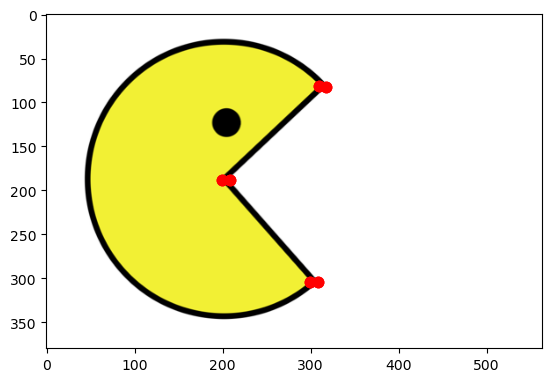

In [14]:
# parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.2,
                       minDistance = 5,
                       blockSize = 5 )


# convert all frames to grayscale # RGB = 3 channels, Gray = 1 channel
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_RGB2GRAY)
gray_3 = cv2.cvtColor(frame_3, cv2.COLOR_RGB2GRAY)


# Take first frame and find corner points in it
pts_1 = cv2.goodFeaturesToTrack(gray_1, mask = None, **feature_params)

# display the detected points
plt.imshow(frame_1)

for p in pts_1:
    # plot x and y detected points
    plt.plot(p[0][0], p[0][1], 'r.', markersize=15)

# print out the x-y locations of the detected points
print(pts_1)

plt.show() # 추가: show the plot

## Perform Optical Flow

Once we've detected keypoints on our initial image of interest, we can calculate the optical flow between this image frame (frame 1) and the next frame (frame 2), using OpenCV's `calcOpticalFlowPyrLK` which is [documented, here](https://docs.opencv.org/trunk/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). It takes in an initial image frame, the next image, and the first set of points, and it returns the detected points in the next frame and a value that indicates how good matches are between points from one frame to the next.

The parameters also include a window size and maxLevels that indicate the size of a window and mnumber of levels that will be used to scale the given images using pyramid scaling; this version peforms an iterative search for matching points and this matching criteria is reflected in the last parameter (you may need to change these values if you are working with a different image, but these should work for the provided example).

## 광학 흐름 수행

관심 있는 초기 이미지에서 키포인트를 감지하면 OpenCV의 `calcOpticalFlowPyrLK`를 사용하여 이 이미지 프레임(프레임 1)과 다음 프레임(프레임 2) 사이의 광학 흐름을 계산할 수 있습니다. 이 함수는 [여기에 문서화되어 있습니다](https://docs.opencv.org/trunk/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). 초기 이미지 프레임, 다음 이미지, 첫 번째 포인트 집합을 가져와 다음 프레임에서 감지된 포인트와 한 프레임에서 다음 프레임으로 포인트 간의 일치도가 얼마나 좋은지를 나타내는 값을 반환합니다.

매개변수에는 창 크기와 창 크기를 나타내는 maxLevels와 피라미드 스케일링을 사용하여 주어진 이미지를 스케일링하는 데 사용되는 레벨 수 m개도 포함됩니다. 이 버전은 일치하는 지점에 대한 반복적인 검색을 수행하며, 이러한 일치 기준은 마지막 매개변수에 반영됩니다(다른 이미지로 작업하는 경우 이러한 값을 변경해야 할 수도 있지만, 제공된 예에서는 작동해야 합니다).

In [15]:
# parameters for lucas kanade optical flow
lk_params = dict( winSize  = (5,5),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


# calculate optical flow between first and second frame
pts_2, match, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, pts_1, None, **lk_params)

# Select good matching points between the two image frames
good_new = pts_2[match==1]
good_old = pts_1[match==1]


In [9]:
print(pts_2)

[[[248.43701  82.75989]]

 [[242.67896 299.76355]]

 [[178.17395 185.29752]]

 [[347.6792   83.29851]]

 [[335.08398 307.0426 ]]

 [[290.14044 193.08896]]]


Next, let's display the resulting motion vectors! You should see the first image with motion vectors drawn on it that indicate the direction of motion from the first frame to the next.

다음으로, 결과 모션 벡터를 표시해 보겠습니다! 첫 번째 이미지에 첫 번째 프레임에서 다음 프레임으로의 모션 방향을 나타내는 모션 벡터가 그려져 있어야 합니다.

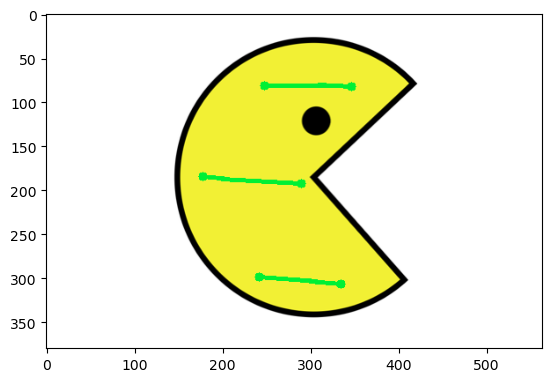

In [16]:
# create a mask image for drawing (u,v) vectors on top of the second frame
mask = np.zeros_like(frame_2)

# draw the lines between the matching points (these lines indicate motion vectors)
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    # draw points on the mask image
    mask = cv2.circle(mask,(int(a),int(b)),5,(200),-1)
    # draw motion vector as lines on the mask image
    mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), (200), 3)
    # add the line image and second frame together

composite_im = np.copy(frame_2)
composite_im[mask!=0] = [0]

plt.imshow(composite_im)

plt.show() # 추가: show the plot

### TODO: Perform Optical Flow between image frames 2 and 3

Repeat this process but for the last two image frames; see what the resulting motion vectors look like. Imagine doing this for a series of image frames and plotting the entire-motion-path of a given object.

### TODO: 이미지 프레임 2와 3 사이에 광학 흐름 수행

마지막 두 이미지 프레임에 대해 이 프로세스를 반복합니다. 결과 모션 벡터가 어떻게 보이는지 확인합니다. 일련의 이미지 프레임에 대해 이 작업을 수행하고 주어진 객체의 전체 모션 경로를 플로팅한다고 상상해 보세요.

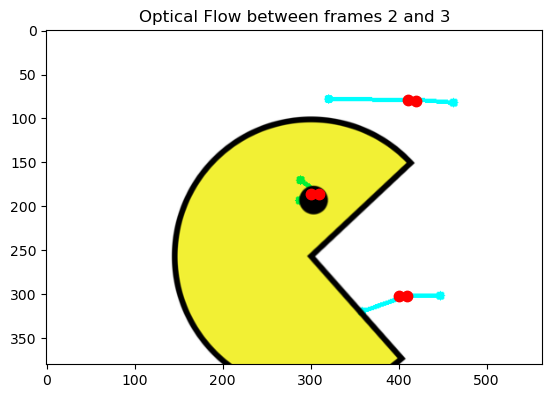

In [18]:
## TODO: Perform optical flow between image frames 2 and 3
# Take second frame and find corner points in it
pts_2_new = cv2.goodFeaturesToTrack(gray_2, mask = None, **feature_params)

for p in pts_2_new:
    # plot x and y detected points
    plt.plot(p[0][0], p[0][1], 'r.', markersize=15)

# Select good matching points between the two image frames
# calculate optical flow between second and third frame
pts_3_new, match, err = cv2.calcOpticalFlowPyrLK(gray_2, gray_3, pts_2_new, None, **lk_params)

# Select good matching points between the two image frames
good_new_2 = pts_3_new[match==1]
good_old_2 = pts_2_new[match==1]

# create a mask image for drawing (u,v) vectors on top of the second frame
mask = np.zeros_like(frame_3)

# draw the lines between the matching points (these lines indicate motion vectors)
for i,(new,old) in enumerate(zip(good_new_2, good_old_2)):
    a,b = new.ravel()
    c,d = old.ravel()
    # draw points on the mask image
    mask = cv2.circle(mask,(int(a),int(b)),5,(200),-1)
    # draw motion vector as lines on the mask image
    mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), (200), 3)
    # add the line image and second frame together

composite_im_new = np.copy(frame_3)
composite_im_new[mask!=0] = [0]

plt.imshow(composite_im_new)
plt.title('Optical Flow between frames 2 and 3')
plt.show() # 추가: show the plot

